# Review paper figure

Notebook to demonstrate the Lompe technique using synthetic simulated data, MHD simulation output values, as input. This means that we have perfect coverage and no uncertainty in the input, and we know what the output should be. To produce the synthetic data, we simulate the magnetospheric response to a solar wind pressure increase using the the Grid Agnostic MHD for Extended Research Applications (GAMERA) code ([Zhang et al. 2019](https://doi.org/10.3847/1538-4365/ab3a4c); [Sorathia et al. 2020](https://doi.org/10.1029/2020GL088227)). 

This is an adapted notebook from the one that produces Figure 4 of the Lompe paper. The figure is slightly modified / simplified.

Start by importing relevant modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
import xarray as xr
import pandas as pd
import lompe
import polplot
from scipy.interpolate import griddata, interp2d, RectBivariateSpline

Load GAMERA / ReMIX data:

In [2]:
# Set datadir to the location of the netcdf file containing GAMERA data
datadir = './sample_dataset/'
ncfile = 'gamera.nc'

assert os.path.exists(datadir + ncfile), "Can't find datafile!"

# load the GAMERA datafile
with xr.open_dataset(datadir + ncfile) as ds:
    fac       = ds['FAC'].values
    potential = ds['potential'].values
    En        = -ds['Etheta'].values
    Ee        = ds['Ephi'].values
    SP        = ds['SigmaPed'].values
    SH        = ds['SigmaHall'].values
    dBr       = ds['dBg_r'].values    
    dBn       = -ds['dBg_theta'].values
    dBe       = ds['dBg_phi'].values
    dBr_space = ds['dBspace_r'].values    
    dBn_space = -ds['dBspace_theta'].values
    dBe_space = ds['dBspace_phi'].values  
    hemi      = ds['hemi'].values
    mlatt     = ds['mlat'].values
    mltt      = ds['mlt'].values
    simtime   = pd.Timestamp(ds['time'].values).to_pydatetime()
    simtimestr = simtime.strftime("%Y-%m-%d %H:%M:%S")
    remixperturbations__dtype = 'ground_mag'

mlt, mlat = np.meshgrid(mltt, mlatt)

Set up cubed sphere grid and interpolate all quantities from GAMERA to that grid

In [3]:
position = (0, 90) # lon, lat for center of the grid
orientation = 0.
L, W, Lres, Wres = 15000e3, 15000e3, 150.e3, 150.e3 # dimensions and resolution of grid, in meters

# inner grid:
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6380e3 + 120e3)

# construct an outer grid, similar to that in the Emodel class:
xi_e  = np.hstack((grid.xi_mesh[0]    , grid.xi_mesh [0 , - 1] + grid.dxi )) - grid.dxi /2 
eta_e = np.hstack((grid.eta_mesh[:, 0], grid.eta_mesh[-1,   0] + grid.deta)) - grid.deta/2 
grid2 = lompe.cs.CSgrid(lompe.cs.CSprojection(grid.projection.position, grid.projection.orientation),
                                  grid.L + grid.Lres, grid.W + grid.Wres, grid.Lres, grid.Wres, 
                                  edges = (xi_e, eta_e), R = grid.R)

def interptogrid(grid, lon, lat, data):
    
    # "G" means Gamera
    xiG, etaG = grid.projection.geo2cube(lon,lat)
    datainterp = griddata((xiG,etaG),data.flatten(), (grid.xi.flatten(),grid.eta.flatten()))
    datainterp = datainterp.reshape(grid.xi.shape)
    
    return datainterp

# interpolate some of the GAMERA output to regular grid:
iii = grid.ingrid(mlt*15, mlat, ext_factor = 1.5)
lonlatcoords  = np.vstack((mlt[iii].flatten() * 15, mlat[iii].flatten()))

SHinterp      = interptogrid(grid , *lonlatcoords, SH[iii].flatten())
SPinterp      = interptogrid(grid , *lonlatcoords, SP[iii].flatten())
potinterp     = interptogrid(grid , *lonlatcoords, potential[iii].flatten())
facinterp     = interptogrid(grid , *lonlatcoords, fac[iii].flatten() * 1e-6)
mltinterp     = interptogrid(grid , *lonlatcoords, mlt[iii]. flatten())
mlatinterp    = interptogrid(grid , *lonlatcoords, mlat[iii].flatten())
Eninterp      = interptogrid(grid , *lonlatcoords, En[iii].flatten())
Eeinterp      = interptogrid(grid , *lonlatcoords, Ee[iii].flatten())
dBrinterp     = interptogrid(grid2, *lonlatcoords, dBr[iii].flatten())
dBninterp     = interptogrid(grid2, *lonlatcoords, dBn[iii].flatten())
dBeinterp     = interptogrid(grid2, *lonlatcoords, dBe[iii].flatten())
dBrsinterp    = interptogrid(grid2, *lonlatcoords, dBr_space[iii].flatten())
dBnsinterp    = interptogrid(grid2, *lonlatcoords, dBn_space[iii].flatten())
dBesinterp    = interptogrid(grid2, *lonlatcoords, dBe_space[iii].flatten())


assert (np.sum(~np.isfinite(SPinterp)) + np.sum(~np.isfinite(SHinterp))) == 0

# conductances
SHfuncCS0 = RectBivariateSpline(grid.xi[0], grid.eta[:,0], SHinterp.T)
SPfuncCS0 = RectBivariateSpline(grid.xi[0], grid.eta[:,0], SPinterp.T)
SHfuncCS = lambda xi, eta : SHfuncCS0(xi, eta, grid = False)
SPfuncCS = lambda xi, eta : SPfuncCS0(xi, eta, grid = False)

def SPfunc(lon, lat):
    ''' Pedersen conductance on grid'''
    xit, etat = grid.projection.geo2cube(lon, lat)
    return SPfuncCS(xit, etat)


def SHfunc(lon, lat):
    ''' Hall conductance on grid'''
    xit, etat = grid.projection.geo2cube(lon, lat)
    return SHfuncCS(xit, etat)

Create data objects for Lompe from the GAMERA output:

In [4]:
rg = np.full(grid2.lat.size, 6380e3)
rs = np.full(grid2.lat.size, 6380e3 + 1000e3)

# electric field
Edata = lompe.Data(np.vstack((Eeinterp.flatten(), Eninterp.flatten())),
                   np.vstack((grid.lon.flatten(), grid.lat.flatten())), datatype='efield', error = 1e-3, iweight = 1)

# magnetic field on ground (east, north, up)
Bg = np.vstack((dBeinterp.flatten(), dBninterp.flatten(), dBrinterp.flatten()))
Bgdata = lompe.Data(Bg, np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rg)), datatype = 'ground_mag', error = 1e-9, iweight = 1)

# magnetic field on space (east, north, up)
Bs = np.vstack((dBesinterp.flatten(), dBnsinterp.flatten(), dBrsinterp.flatten()))
Bsdata = lompe.Data(Bs, np.vstack((grid2.lon.flatten(), grid2.lat.flatten(), rs)), datatype = 'space_mag_fac', error = 1e-9, iweight = 1)

# field-aligned current
FACdata = lompe.Data(facinterp.flatten() * grid2.R / rs.flatten()[0], np.vstack((grid.lon.flatten(), grid.lat.flatten())),
                      datatype = 'fac', error = 1e-6, iweight = 1)

# corresponding names and regularization for the data sets
names = ['Electric field', 'FAC', 'Ground $\Delta B$', 'Space $\Delta B$']
datasets = [Edata, FACdata, Bgdata, Bsdata]
regparams = np.array([0, 1, 10, 10]) * 1e-2

datasets = dict(zip(names, datasets))
regparams = dict(zip(names, regparams))

/Users/laundal/BCSS-DAG Dropbox/Karl Laundal/git/installable/lompe/lompe/model/data.py:158: UserWarning: Warning: FAC data must be defined on the whole Emodel.grid_J, but this is not checked.
  warnings.warn('Warning: FAC data must be defined on the whole Emodel.grid_J, but this is not checked.', UserWarning)


Create Lompe model object

In [5]:
emodel = lompe.Emodel(grid, Hall_Pedersen_conductance=(SHfunc, SPfunc), dipole = True)

gridB = emodel.grid_J
grid2 = emodel.grid_E


Vary the input and compare the output to simulation and plot overview figure

Electric field
FAC
Ground $\Delta B$
Space $\Delta B$


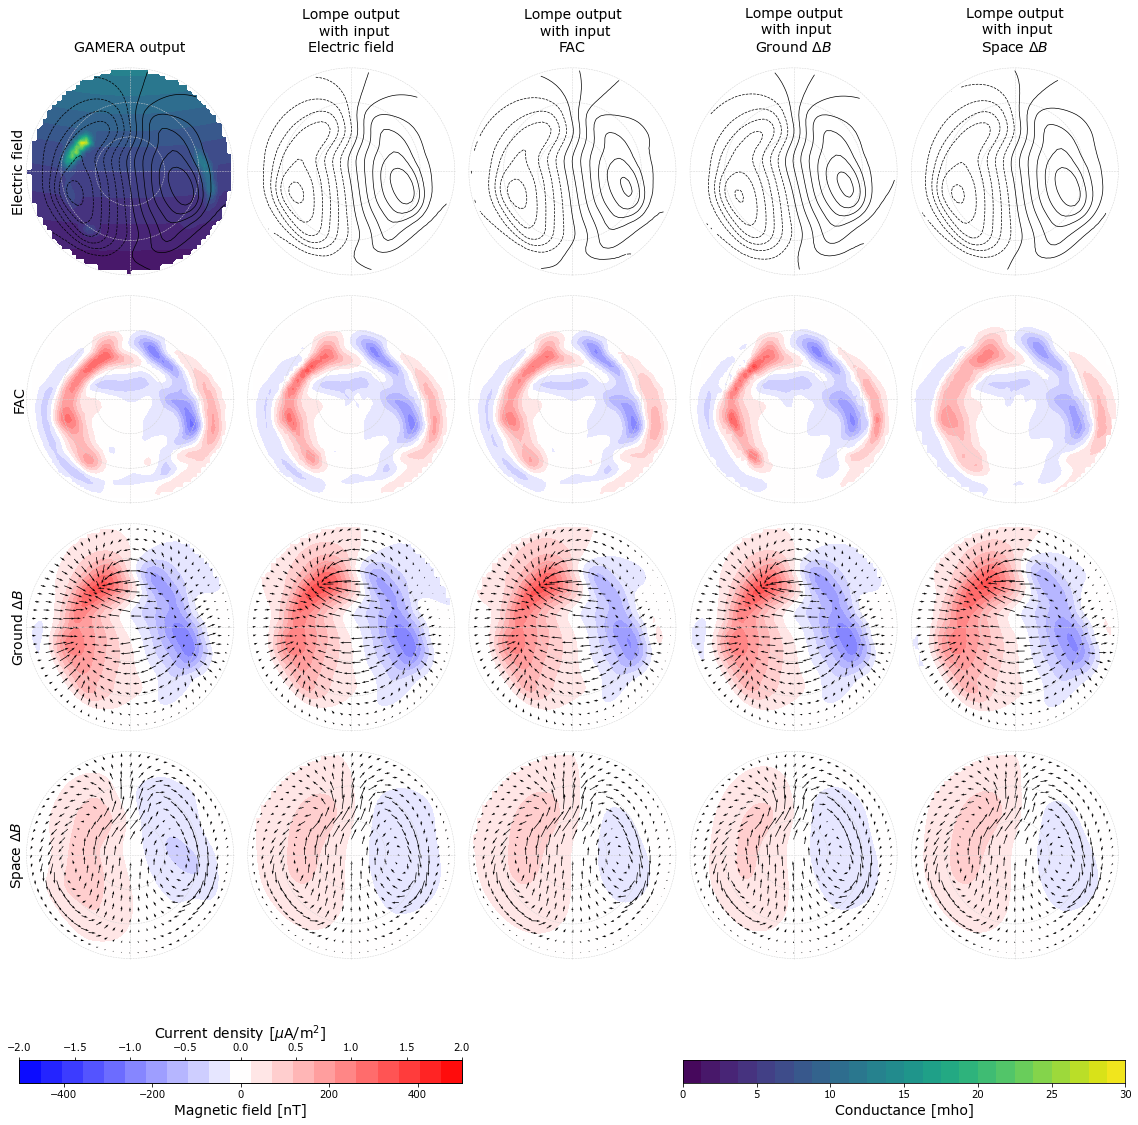

In [7]:
# set up the subplots:
ncols = len(names) + 1 
nrows = len(names)
res = 10 # the colorbars will be 1/res the height of the other plots


#  get a grid for plotting vectors:
mlatmlt, mltres = polplot.grids.equal_area_grid(dr = 3, N = 9)
vmlat, vmlt = mlatmlt

fig = plt.figure(figsize = (16, 16), facecolor = 'white')
gs = gridspec.GridSpec(ncols * (res - 1) , res * nrows + res)
axes = np.array([[plt.subplot(gs[(i * res):(i+1)*res, (j*res):(j+1)*res]) for j in range(ncols)] for i in range(nrows)])
paxes = np.array([polplot.Polarplot(_ax, minlat = 60) for _ax in axes.flatten()]).reshape(axes.shape)

# color scales:
blevels = np.linspace(-500e-9, 500e-9, 22) # B color levels
jlevels = np.linspace(-2e-6, 2e-6, 22)     # FAC color levels 
clevels = np.linspace(0, 30, 25)           # conductance color levels

for i in range(nrows):
    # vary data input to Lompe
    emodel.clear_model()
    emodel.add_data(datasets[names[i]])
    # run inversion
    print(names[i])
    gtg, gtd = emodel.run_inversion(l1 = regparams[names[i]], l2 = 0)

    fac = emodel.FAC().reshape(gridB.shape)

    pot = emodel.E_pot().reshape(gridB.shape) * 1e-3

    pot = pot + potinterp[0, 0] - pot[0, 0] # add a constant to fitted potential to align with original
    
    # plot the Lompe output
    paxes[0, i+1].contour(gridB.lat, gridB.lon/15, pot, levels = np.r_[-200:201:10], colors = 'black', linewidths = .7)
    paxes[1, i+1].contourf(gridB.lat, gridB.lon/15, fac, cmap = plt.cm.bwr, levels = np.linspace(-2e-6, 2e-6, 22))

    B_ground_scalar = emodel.B_ground(r = rg)
    paxes[2, i+1].contourf(grid2.lat, grid2.lon/15, B_ground_scalar[2].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))

    B_ground_vector = emodel.B_ground(lat = vmlat, lon = vmlt*15, r = rg[0])
    paxes[2, i+1].quiver(vmlat, vmlt, B_ground_vector[1], B_ground_vector[0])

    
    B_space_scalar = emodel.B_space(r = rs)
    paxes[3, i+1].contourf(grid2.lat, grid2.lon/15, B_space_scalar[2].reshape(grid2.shape), cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))

    B_space_vector = emodel.B_space(lat = vmlat, lon = vmlt*15, r = rs[0])
    paxes[3, i+1].quiver(vmlat, vmlt, B_space_vector[1], B_space_vector[0])

    if i == 0:
        for j in range(nrows):
            axes[ 0, j + 1].set_title('Lompe output\n with input\n' + names[j], size = 14)
    
# plot GAMERA output in first row:
paxes[0, 0].contourf(grid.lat, grid.lon/15, SHinterp  , levels = np.linspace(0, 30, 25))
paxes[0, 0].contour( grid.lat, grid.lon/15, potinterp , levels = np.r_[-200:201:10], colors = 'black', linewidths = .7)    
paxes[1, 0].contourf(grid.lat, grid.lon/15, facinterp , cmap = plt.cm.bwr, levels = np.linspace(-2e-6, 2e-6, 22))
paxes[2, 0].contourf(grid2.lat, grid2.lon/15, dBrinterp , cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))
paxes[3, 0].contourf(grid2.lat, grid2.lon/15, dBrsinterp , cmap = plt.cm.bwr, levels = np.linspace(-500e-9, 500e-9, 22))

# plot GAMERA magnetic field vectors - first interpolate to the vector grid. Do this in cubed sphere coords
xi_ , eta_  = grid.projection.geo2cube(grid2.lon.flatten(), grid2.lat.flatten())
xi_v, eta_v = grid.projection.geo2cube(vmlt * 15, vmlat)
# ground
Beg_v = griddata(np.vstack((xi_, eta_)).T, dBeinterp.flatten(), np.vstack((xi_v, eta_v)).T)
Bng_v = griddata(np.vstack((xi_, eta_)).T, dBninterp.flatten(), np.vstack((xi_v, eta_v)).T)
paxes[2, 0].quiver(vmlat, vmlt, Bng_v, Beg_v)
# space
Bes_v = griddata(np.vstack((xi_, eta_)).T, dBesinterp.flatten(), np.vstack((xi_v, eta_v)).T)
Bns_v = griddata(np.vstack((xi_, eta_)).T, dBnsinterp.flatten(), np.vstack((xi_v, eta_v)).T)
paxes[3, 0].quiver(vmlat, vmlt, Bns_v, Bes_v)





for i in range(nrows):
    paxes[i, 0].text(60, 18, names[i], size = 14, ha = 'right', rotation = 90, va = 'center')

axes[ 0, 0].set_title('GAMERA output', size = 14)

    

# draw colorbars:
cbar_ax1  = plt.subplot(gs[-1, 0:res*2])
cbar_ax1_ = plt.twiny(cbar_ax1)
cbar_ax1_.set_xlim(jlevels[0]*1e6, jlevels[-1]*1e6)
cbar_ax1_.set_xlabel('Current density [$\mu$A/m$^2$]', size = 14)

cbar_ax1.contourf(np.vstack((blevels, blevels))*1e9, np.vstack((blevels*0, blevels*0+1)), np.vstack((blevels, blevels)), cmap = plt.cm.bwr, levels = blevels)
cbar_ax1.set_xlabel('Magnetic field [nT]', size = 14)

cbar_ax2 = plt.subplot(gs[-1, 3*res:5*res])
cbar_ax2.contourf(np.vstack((clevels, clevels)), np.vstack((clevels*0, clevels*0+1)), np.vstack((clevels, clevels)), levels = clevels)
cbar_ax2.set_xlabel('Conductance [mho]', size = 14)

for a in [cbar_ax1, cbar_ax2]:
    a.set_yticks([])

# adjust plots, remove axis labels
plt.subplots_adjust(left = 0.03, right = .99, top = .94, bottom = .05, wspace = 0, hspace = 0)

plt.savefig('ideal_lompe_example.pdf')
plt.savefig('ideal_lompe_example.png', dpi = 250)
plt.show()



The figure now shows the results of Lompe inversions with synthetic data from GAMERA (shown in the left column). The rest of the columns show the Lompe inversion outputs. The rows correspond to different inputs to the inversion, indicated above the top row. The inversion result can be assessed by comparing the plots to the left column with GAMERA output (figure constructed earlier in notebook), which can be considered to be the ground truth in this experiment.